In [1]:
# Libraries
import os
import pathlib

import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101

from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")



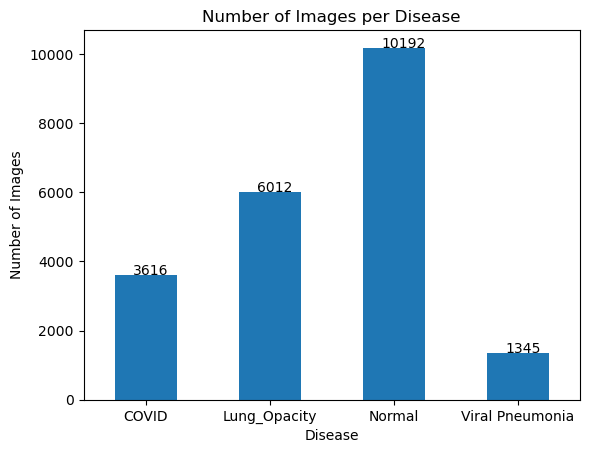

Training data size = 16932, Validation data size = 2116, Testing data size = 2117


In [2]:
# Set the directory containing the image files
data_dir = 'COVID-19_Radiography_Dataset'

# Lists to store filepaths and their labels
filepaths = []
labels = []

# Get all the files present in all 4 folders in the dataset directory and map them to a class name based on what folder it is present
for fold in os.listdir(data_dir):
    foldpath = os.path.join(data_dir, fold)

    if pathlib.Path(foldpath).suffix != '':
        continue
    if os.path.isdir(foldpath):
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            if os.path.isdir(fpath):
                if pathlib.Path(foldpath).suffix == '':
                    # We will not be using Mask Images so ignoring the mask folders
                    if pathlib.Path(fpath).parts[-1] == 'masks' or pathlib.Path(fpath).parts[-1] == 'Masks' or pathlib.Path(fpath).parts[-1] == 'MASKS':
                        continue
                    else:
                        o_file = os.listdir(fpath)
                        for f in o_file:
                            ipath = os.path.join(fpath, f)
                            filepaths.append(ipath)
                            labels.append(fold)
                else:
                    filepaths.append(fpath)
                    labels.append(fold)

# Storing File names and corresponding class in a dataframe
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})


# show the plot to visualize number of images per class
label_counts = df.groupby('labels')['filepaths'].count()
ax = label_counts.plot(kind='bar')

plt.xlabel('Disease')
plt.ylabel('Number of Images')
plt.title('Number of Images per Disease')
plt.xticks(rotation=0)

for i in ax.patches:
    ax.text(i.get_x()+.15, i.get_height()+.5, str(i.get_height()), fontsize=10)
plt.show()

# Split the Data into training, validation, and test sets at a ratio of 80-10-10
strat = df['labels']
train_df, semi_split_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)
strat = semi_split_df['labels']
valid_df, test_df = train_test_split(semi_split_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)


print(f'Training data size = {len(train_df)}, Validation data size = {len(valid_df)}, Testing data size = {len(test_df)}')


In [3]:
img_size = (224, 224)
channels = 3 # either BGR or Grayscale
color = 'rgb'
img_shape = (img_size[0], img_size[1], channels)
batch_size = 16


ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size


def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= color, shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= color, shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= color, shuffle= False, batch_size= test_batch_size)

Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


In [4]:
def get_predictions(model, test_data):
    preds = model.predict_generator(test_data)
    y_pred = np.argmax(preds, axis=1)
    return y_pred

In [5]:
def plot_confusion_matrix(model_name,true_labels, pred_labels):
    cm_array = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(cm_array, annot=True, fmt='d', cmap='Blues')

    # Add labels, title, and ticks to the plot
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix of ' + str(model_name))
    plt.xticks(ticks=[0, 1, 2, 3], labels=classes)
    plt.yticks(ticks=[0, 1, 2, 3], labels=classes)
    plt.show()
    return cm_array

In [6]:
def roundup(input_value):
    return round(input_value * 100, 2)

In [7]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
true_labels = test_gen.classes

### Load Models

In [8]:
LeNet = keras.models.load_model('/Users/kysgattu/Desktop/ChestXRayClassification/LeNet_Saved.h5')

Metal device set to: Apple M1 Pro


2023-04-19 19:57:26.953746: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-19 19:57:26.953834: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
VGG = keras.models.load_model('/Users/kysgattu/Desktop/ChestXRayClassification/VGG.h5')

In [10]:
DenseNet = keras.models.load_model('/Users/kysgattu/Desktop/ChestXRayClassification/DenseNet_Saved.h5')

In [11]:
ResNet = keras.models.load_model('/Users/kysgattu/Desktop/ChestXRayClassification/ResNet_Saved.h5')

### Evaluate Models Against Test Set

In [12]:
LeNet_Accuracy = LeNet.evaluate(test_gen)[1]

2023-04-19 19:57:33.574343: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-19 19:57:33.632860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 4s 140ms/step - loss: 0.6041 - accuracy: 0.7837


In [13]:
VGG_Accuracy = VGG.evaluate(test_gen)[1]

2023-04-19 19:57:38.096298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 22s 748ms/step - loss: 0.2503 - accuracy: 0.9140


In [14]:
DenseNet_Accuracy = DenseNet.evaluate(test_gen)[1]

2023-04-19 19:58:01.064864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 17s 517ms/step - loss: 0.4772 - accuracy: 0.8559


In [15]:
ResNet_Accuracy = ResNet.evaluate(test_gen)[1]

2023-04-19 19:58:17.779866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 18s 583ms/step - loss: 0.2326 - accuracy: 0.9258


In [16]:
print("Accuracy of LeNet against the Test Set: " + str(roundup(LeNet_Accuracy))+"%")
print("Accuracy of VGG against the Test Set: " + str(roundup(VGG_Accuracy))+"%")
print("Accuracy of DenseNet against the Test Set: " + str(roundup(DenseNet_Accuracy))+"%")
print("Accuracy of ResNet against the Test Set: " + str(roundup(ResNet_Accuracy))+"%")

Accuracy of LeNet against the Test Set: 78.37%
Accuracy of VGG against the Test Set: 91.4%
Accuracy of DenseNet against the Test Set: 85.59%
Accuracy of ResNet against the Test Set: 92.58%


### Get Predictions of Models

In [17]:
Lenet_preds = get_predictions(LeNet, test_gen)

2023-04-19 19:58:35.473301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [18]:
VGG_preds = get_predictions(VGG, test_gen)

2023-04-19 19:58:39.516124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [19]:
DenseNet_preds = get_predictions(DenseNet, test_gen)

2023-04-19 19:59:02.060310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [20]:
ResNet_preds = get_predictions(ResNet, test_gen)

2023-04-19 19:59:19.187142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Get Classification Reports

In [21]:
LeNet_CR = classification_report(true_labels, Lenet_preds, target_names= classes)

In [22]:
VGG_CR = classification_report(true_labels, VGG_preds, target_names= classes)

In [23]:
DenseNet_CR = classification_report(true_labels, DenseNet_preds, target_names= classes)

In [24]:
ResNet_CR = classification_report(true_labels, ResNet_preds, target_names= classes)

In [25]:
print("----------------------------------------------------------------")
print("Classification Report of LeNet")
print("----------------------------------------------------------------")
print(LeNet_CR)
print("----------------------------------------------------------------")

print("----------------------------------------------------------------")
print("Classification Report of VGG")
print("----------------------------------------------------------------")
print(VGG_CR)
print("----------------------------------------------------------------")

print("----------------------------------------------------------------")
print("Classification Report of DenseNet")
print("----------------------------------------------------------------")
print(DenseNet_CR)
print("----------------------------------------------------------------")

print("----------------------------------------------------------------")
print("Classification Report of ResNet")
print("----------------------------------------------------------------")
print(ResNet_CR)
print("----------------------------------------------------------------")


----------------------------------------------------------------
Classification Report of LeNet
----------------------------------------------------------------
                 precision    recall  f1-score   support

          COVID       0.81      0.65      0.73       362
   Lung_Opacity       0.74      0.71      0.73       602
         Normal       0.79      0.86      0.82      1019
Viral Pneumonia       0.86      0.86      0.86       134

       accuracy                           0.78      2117
      macro avg       0.80      0.77      0.78      2117
   weighted avg       0.78      0.78      0.78      2117

----------------------------------------------------------------
----------------------------------------------------------------
Classification Report of VGG
----------------------------------------------------------------
                 precision    recall  f1-score   support

          COVID       0.91      0.93      0.92       362
   Lung_Opacity       0.88      0.89     

### Plot Confusion Matrices

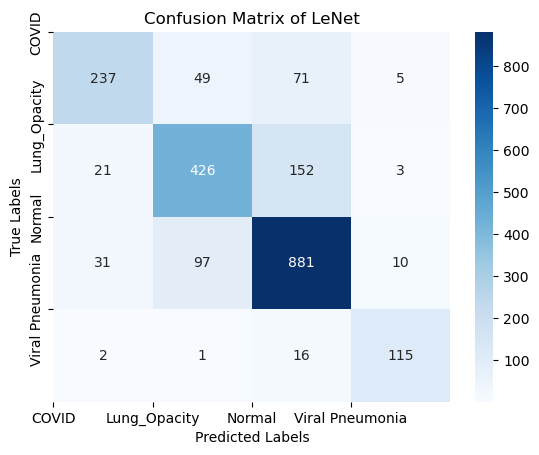

In [26]:
LeNet_CM = plot_confusion_matrix('LeNet',true_labels, Lenet_preds)

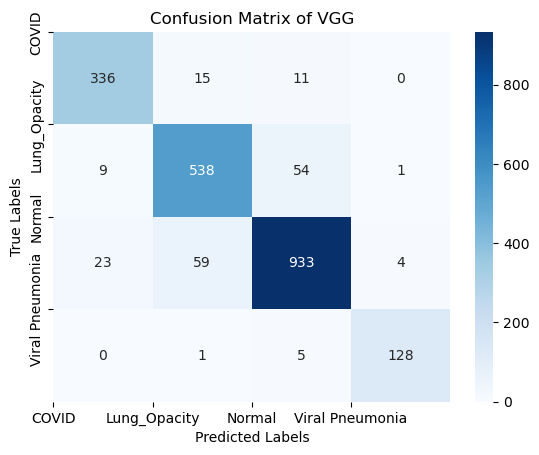

In [27]:
VGG_CM = plot_confusion_matrix('VGG',true_labels, VGG_preds)

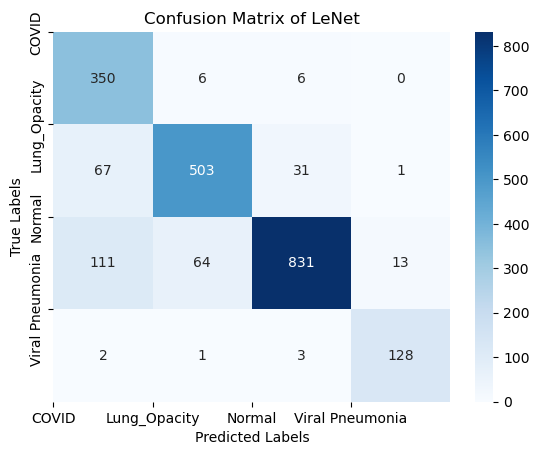

In [28]:
DenseNet_CM = plot_confusion_matrix('LeNet',true_labels, DenseNet_preds)

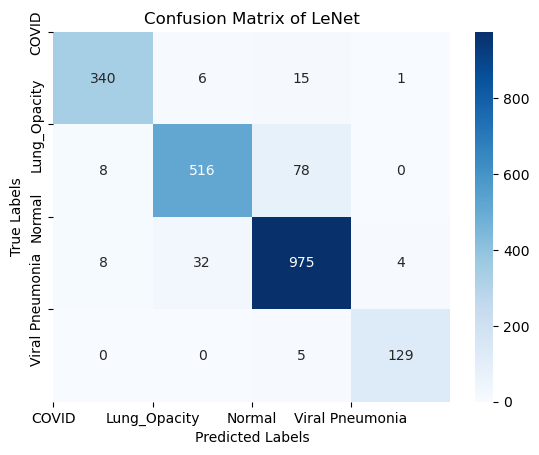

In [29]:
ResNet_CM = plot_confusion_matrix('LeNet',true_labels, ResNet_preds)